# Predicting Hospital Readmission for Diabetes Patients

## Objective
Demonstrate an end-to-end machine learning pipeline to predict whether a patient will be readmitted to a hospital after a diabetes diagnosis using data maintained by UCI detailing 10 years of clinical care at U.S. hospitals and integrated delivery networks.

## Table of Contents
* [Data Loading](#data_loading)
* [Data Cleaning & Preprocessing](#data_cleaning)
* [Exploratory Data Analysis (EDA)](#eda)
    * [Expore numeric data](#eda_numeric)
    * [Explore categorical data](#eda_categorical)
* [Feature Engineering](#feature_engineering)
* [Model Training & Evaluation](#model_training)

In [1]:
import io
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

from imblearn.combine import SMOTETomek
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier

import requests

%matplotlib inline

## Data Loading <a class="anchor" id="data_loading"></a>

In [2]:
# URL of the dataset
url = "https://archive.ics.uci.edu/static/public/296/diabetes+130-us+hospitals+for+years+1999-2008.zip"

try:
    print("Downloading dataset...")
    response = requests.get(url, stream=True)
    response.raise_for_status() # raises error for bad HTTP responses

    print("Download successful! Extracting files...")
    zip_file = zipfile.ZipFile(io.BytesIO(response.content)) # open ZIP in memory

    # list the files
    files_list = zip_file.namelist()
    print("Files contained in ZIP:\n", ", ".join(files_list))

    # create a dictionary to store the files
    files = {}

    for file_name in files_list:
        with zip_file.open(file_name) as f:
            files[file_name] = pd.read_csv(f)

    # assign the DataFrames to variables
    df_diabetes = files.get("diabetic_data.csv")
    df_ids = files.get("IDS_mapping.csv")

except requests.exceptions.RequestException as e:
    print(f"Error downloading dataset: {e}")

except zipfile.BadZipFile:
    print("Error processing ZIP file")

except OSError as e:
    print(f"Error opening file: {e}")

except KeyError as e:
    print(f"Error retrieving file: {e}")

Download successful! Extracting files...
Files contained in ZIP:
 diabetic_data.csv, IDS_mapping.csv


## Data Cleaning & Preprocessing <a class="anchor" id="data_cleaning"></a>

In [3]:
# prepare the IDs DF for merging
df_ids.dropna(inplace=True)
df_filtered_ids = df_ids[df_ids["admission_type_id"].str.isdigit()].copy()
df_grouped_ids = df_filtered_ids.groupby("admission_type_id")["description"].apply(lambda x: " | ".join(x)).reset_index()

# prepare the diabetes DF for merging
df_diabetes["admission_type_id"] = df_diabetes["admission_type_id"].astype(str)

# merge the DFs
df = df_diabetes.merge(df_grouped_ids, how="left", on="admission_type_id")

In [4]:
# look at the data types
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id           object
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [5]:
# identify columns using a question mark as a null value
question_mark_cols = ", ".join(df.columns[(df == "?").any()])
print("Columns using \"?\" to signify null values:\n", question_mark_cols)

# replace "?" rows with NaN
df.where(df != "?", np.nan, inplace=True)

Columns using "?" to signify null values:
 race, weight, payer_code, medical_specialty, diag_1, diag_2, diag_3


In [6]:
def display_missing_value_columns(df):
    """Generates a DataFrame analyzing columns' null values.

    Args:
        df (pd.DataFrame): A dataset.

    Returns:
        pd.DataFrame: A DataFrame containing null statistics.
    """

    # get columns and their missing value counts
    missing_values = df.isna().sum()
    missing_values = missing_values[missing_values > 0].reset_index()

    # rename the columns and calculate the percentage of nulls
    missing_values.columns = ["column_name", "null_count"]
    missing_values["null_perc"] = missing_values["null_count"] / df.shape[0]

    # sort the values
    missing_values.sort_values(by="null_perc", ascending=False, inplace=True)

    return missing_values

In [7]:
# create a DF showing missing value statistics
display_missing_value_columns(df)

,column_name,null_count,null_perc
1,weight,98569,0.968585
7,max_glu_serum,96420,0.947468
8,A1Cresult,84748,0.832773
3,medical_specialty,49949,0.490822
2,payer_code,40256,0.395574
0,race,2273,0.022336
6,diag_3,1423,0.013983
5,diag_2,358,0.003518
4,diag_1,21,0.000206


In [8]:
# drop columns with 30% or more values missing
non_na_vals = df.shape[0] - (0.3 * df.shape[0])
df.dropna(thresh=non_na_vals, axis=1, inplace=True)

# drop the remaining null rows
df.dropna(inplace=True)

In [9]:
# check for duplicates
print(f"Total duplicate rows: {df.duplicated().sum()}")
df[df.duplicated()]

Total duplicate rows: 0


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description


In [10]:
# check for duplicate patient numbers (i.e., more than one encounter per patient)
grouped_patient_nbrs = df.groupby("patient_nbr")["encounter_id"].count().reset_index()
grouped_patient_nbrs.sort_values(by="encounter_id", ascending=False)

,patient_nbr,encounter_id
52030,88785891,39
15744,23199021,23
51618,88227540,23
3380,1660293,23
17718,23643405,22
...,...,...
25966,36531909,1
25967,36534087,1
25968,36535347,1
25970,36539487,1


In [11]:
# sort to keep only the patient number for the most recent encounter
df.sort_values(by=["patient_nbr", "encounter_id"], ascending=[True, False], inplace=True)
df.drop_duplicates(subset="patient_nbr", inplace=True)

In [12]:
# cast any identifer columns to an object type
cols_to_convert = df.filter(regex=r"_(?:id|nbr)$").columns
df[cols_to_convert] = df[cols_to_convert].astype(str)

In [13]:
# replace the age ranges with integer types that represent the average of that interval
df["age"] = df["age"].map({
    "[0-10)": 5, "[10-20)": 15, "[20-30)": 25, "[30-40)": 35, "[40-50)": 45,
    "[50-60)": 55, "[60-70)": 65, "[70-80)": 75, "[80-90)": 85, "[90-100)": 95})

In [14]:
# filter the data to keep only readmissions within a month
df = df[df["readmitted"].ne(">30")].copy()

In [15]:
def map_icd9_to_category(code):
    """Maps ICD-9 codes to disease categories.

    Args:
        code (str): A string value representing an ICD-9 code.
    Returns:
        str: A string value representing a disease classification.
    """

    try:
        code = str(code).strip()
        if code.startswith("250"):
            category =  "Diabetes-Related"
        elif code.startswith("E"):
            category =  "Supplementary Classification of External Causes of Injury and Poisoning"
        elif code.startswith("V"):
            category =  "Supplementary Classification of Factors influencing Health Status and Contact with Health Services"

        code = int(float(code))
        if 1 <= code <= 139:
            category =  "Infectious and Parasitic Diseases"
        elif 140 <= code <= 239:
            category =  "Neoplasms"
        elif 240 <= code <= 279:
            category =  "Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders"
        elif 280 <= code <= 289:
            category =  "Diseases of the Blood and Blood-forming Organs"
        elif 290 <= code <= 319:
            category =  "Mental Disorders"
        elif 320 <= code <= 389:
            category =  "Diseases of the Nervous System and Sense Organs"
        elif 390 <= code <= 459:
            category =  "Diseases of the Circulatory System"
        elif 460 <= code <= 519:
            category =  "Diseases of the Respiratory System"
        elif 520 <= code <= 579:
            category =  "Diseases of the Digestive System"
        elif 580 <= code <= 629:
            category =  "Diseases of the Genitourinary System"
        elif 630 <= code <= 679:
            category =  "Complications of Pregnancy, Childbirth, and the Puerperium"
        elif 680 <= code <= 709:
            category =  "Diseases of the Skin and Subcutaneous Tissue"
        elif 710 <= code <= 739:
            category =  "Diseases of the Musculoskeletal System and Connective Tissue"
        elif 740 <= code <= 759:
            category =  "Congenital Anomalies"
        elif 760 <= code <= 779:
            category =  "Certain Conditions originating in the Perinatal Period"
        elif 780 <= code <= 799:
            category =  "Symptoms, Signs and Ill-defined Conditions"
        elif 800 <= code <= 999:
            category =  "Injury and Poisoning"
        else:
            category =  "Other"

    except:
        category =  "Other"

    return category

In [16]:
# convert ICD-9 codes to disease categories
df[["disease_class_1", "disease_class_2", "disease_class_3"]] = df[["diag_1", "diag_2", "diag_3"]].apply(lambda col: col.map(map_icd9_to_category, na_action="ignore"))

## Exploratory Data Analysis <a class="anchor" id="eda"></a>

### Explore numeric data <a class="anchor" id="eda_numeric"></a>

In [17]:
# look at descriptive statistics for numeric columns
df.describe()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,55029.000000,55029.000000,55029.000000,55029.000000,55029.000000,55029.000000,55029.000000,55029.000000,55029.000000
mean,66.053808,4.320431,42.795599,1.422377,15.869560,0.287721,0.118483,0.418125,7.348961
std,15.760961,2.983919,19.844312,1.739200,8.407061,1.072697,0.562924,0.942256,1.893806
min,5.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,55.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,65.000000,4.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000
75%,75.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,95.000000,14.000000,126.000000,6.000000,81.000000,40.000000,37.000000,16.000000,16.000000


In [18]:
def plot_numeric_distributions(df):
    """Generates a grid of boxplots and histograms for numeric columns.

    Args:
        df (pd.DataFrame): A dataset with numeric data.
    """

    # identify numeric columns
    numeric_cols = sorted(df.select_dtypes(include="number").columns)

    # get the number of numeric columns
    num_cols = len(numeric_cols)

    # create a figure and set of subplots
    fig, axes = plt.subplots(num_cols, 2, figsize=(10, 5 * num_cols))

    # create a side-by-side boxplot and histogram for each row
    for i, col in enumerate(numeric_cols):
        sns.boxplot(data=df, x=col, color="mediumvioletred", ax=axes[i, 0])
        axes[i, 0].set_title(f"Boxplot of {col}")

        sns.histplot(data=df, x=col, color="lightcoral", ax=axes[i, 1])
        axes[i, 1].set_title(f"Histogram of {col}")

    # prevent overlap and display figure
    plt.tight_layout()
    plt.show()

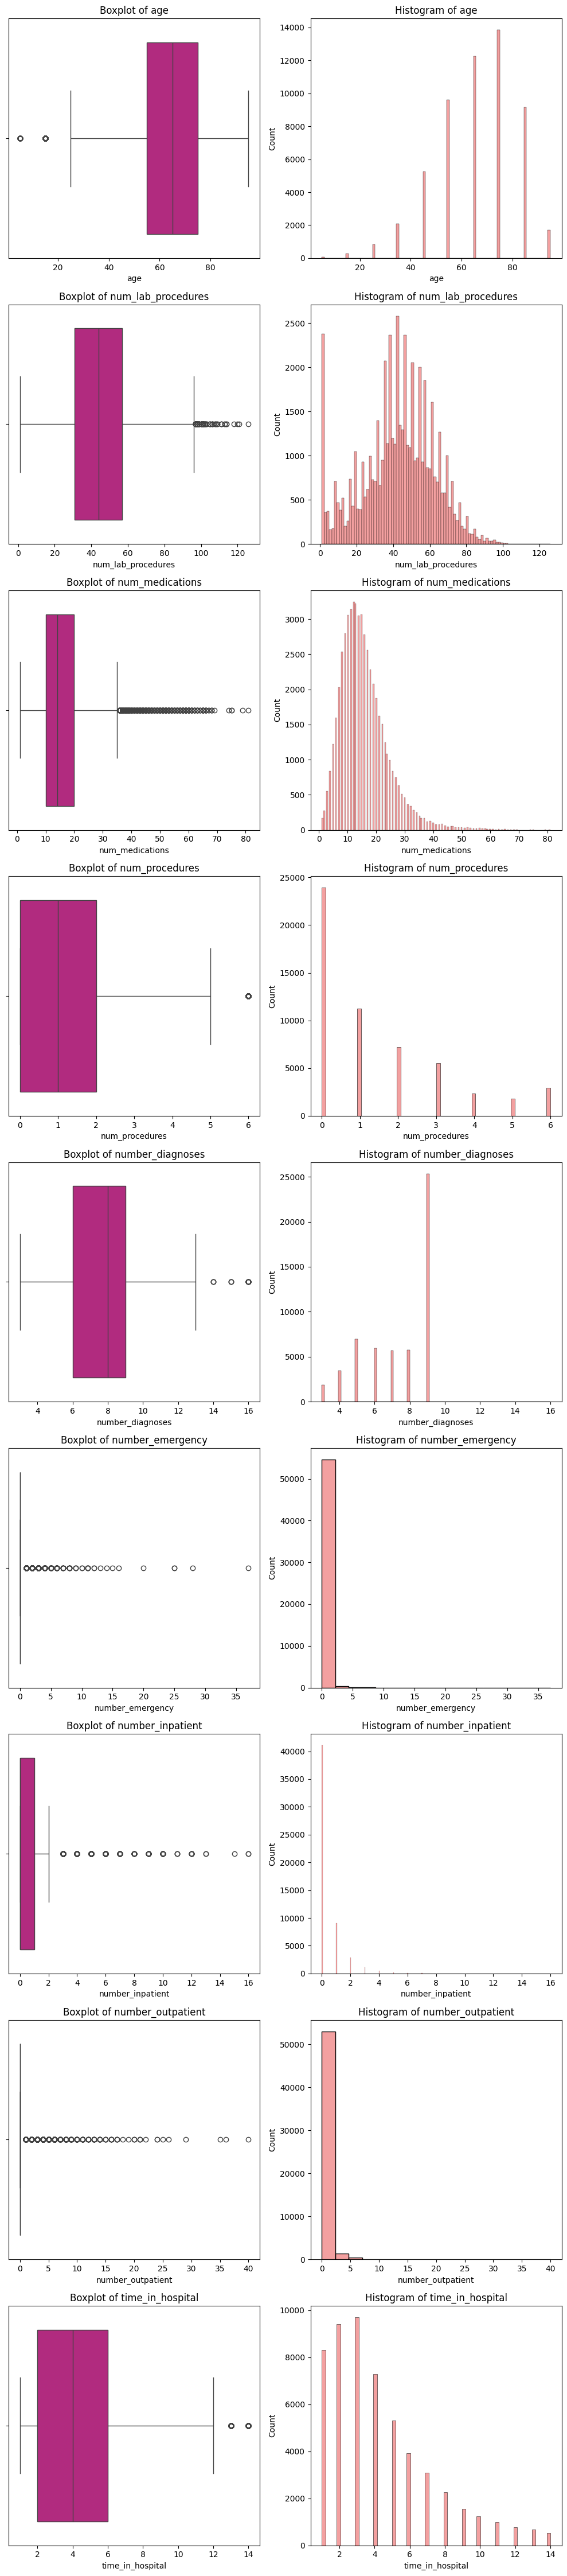

In [19]:
# analyze the distributions in the numeric data
plot_numeric_distributions(df)

In [20]:
def display_skewness_columns(df):
    """Generates a DataFrame analyzing columns' skewness.

    Args:
        df (pd.DataFrame): A dataset containing numeric data.

    Returns:
        pd.DataFrame: A DataFrame containing skewness values.
    """

    # check for skewness and rename columns
    skewness = df.select_dtypes(include="number").skew().reset_index()
    skewness.columns = ["column_name", "value"]

    # categorize the skewness
    conditions = [skewness["value"].abs().between(0.5, 1), skewness["value"].abs() > 1]
    choices = ["Moderate", "High"]
    skewness["skew_category"] = np.select(conditions, choices, default="Symmetric")

    # sort the values
    skewness.sort_values(by="value", ascending=False, inplace=True)

    return skewness

In [21]:
# create a DF showing skewness
display_skewness_columns(df)

,column_name,value,skew_category
6,number_emergency,17.183030,High
5,number_outpatient,9.050615,High
7,number_inpatient,3.910503,High
4,num_medications,1.418247,High
3,num_procedures,1.230317,High
1,time_in_hospital,1.162434,High
2,num_lab_procedures,-0.200487,Symmetric
0,age,-0.550626,Moderate
8,number_diagnoses,-0.672531,Moderate


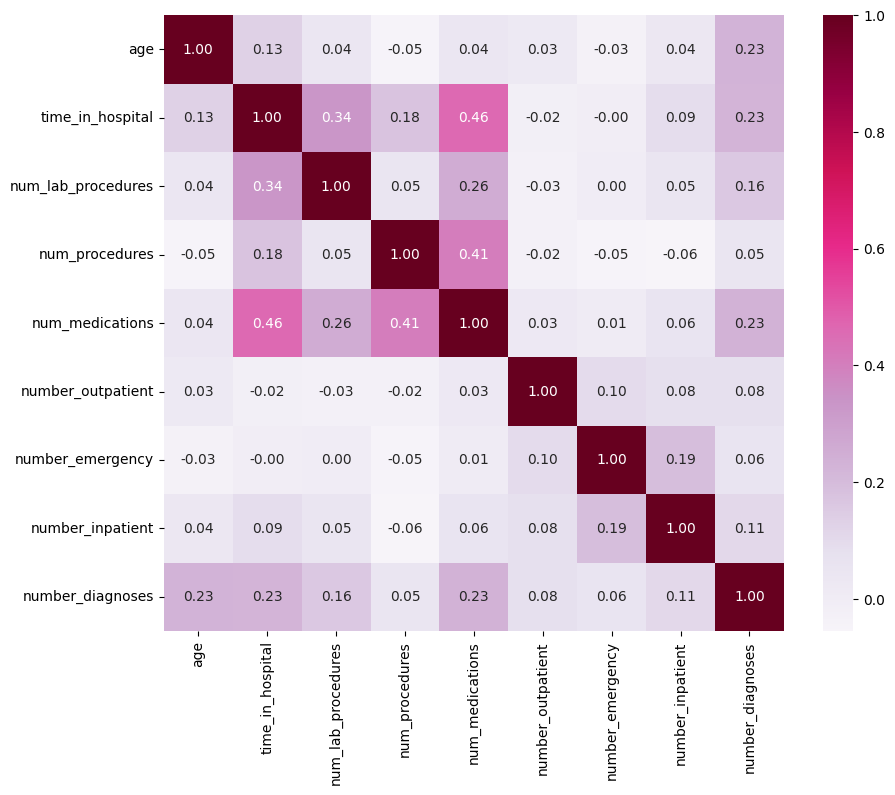

In [22]:
# analyze the strength of relationships among numeric columns
plt.figure(figsize=(10, 8))
corr_df = df.corr(numeric_only=True)
sns.heatmap(corr_df, cmap="PuRd", annot=True, fmt=".2f")
plt.show()

### Explore categorical data <a class="anchor" id="eda_categorical"></a>

In [23]:
# look at descriptive statistics for categorical columns
df.describe(include="object")

,encounter_id,patient_nbr,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,diag_1,diag_2,diag_3,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description,disease_class_1,disease_class_2,disease_class_3
count,55029,55029,55029,55029,55029,55029,55029,55029,55029,55029,...,55029,55029,55029,55029,55029,55029,55029,55029,55029,55029
unique,55029,55029,5,3,8,26,17,667,683,725,...,1,1,2,2,2,2,8,17,17,17
top,29758806,378,Caucasian,Female,1,1,7,414,250,250,...,No,No,No,No,Yes,NO,Emergency | Discharged to home | Physician Re...,Diseases of the Circulatory System,Diseases of the Circulatory System,Diseases of the Circulatory System
freq,1,1,41912,29186,28663,32542,29692,3855,3580,7020,...,55029,55029,55028,30710,41084,51865,28663,16342,16816,16173


In [24]:
def display_cardinality_columns(df):
    """Generates a DataFrame analyzing columns' cardinality.

    Args:
        df (pd.DataFrame): A dataset.

    Returns:
        pd.DataFrame: A DataFrame containing cardinality statistics.
    """

    # get columns and their number of unique values
    cardinal_values = df.select_dtypes(include=["category", "object"]).nunique().reset_index()

    # rename the columns and categorize the skewness
    cardinal_values.columns = ["column_name", "num_unique"]
    cardinal_values["cardinality"] = cardinal_values["num_unique"].apply(lambda x: "Low" if x < 15 else "Moderate" if 15 <= x < 50 else "High")

    # sort the values
    cardinal_values.sort_values(by="num_unique", ascending=False, inplace=True)

    return cardinal_values

In [25]:
# create a DF showing cardinality
display_cardinality_columns(df)

,column_name,num_unique,cardinality
0,encounter_id,55029,High
1,patient_nbr,55029,High
9,diag_3,725,High
8,diag_2,683,High
7,diag_1,667,High
5,discharge_disposition_id,26,Moderate
38,disease_class_2,17,Moderate
37,disease_class_1,17,Moderate
39,disease_class_3,17,Moderate
6,admission_source_id,17,Moderate


In [26]:
def plot_categorical_distributions(df, threshold=5):
    """Generates a grid of violin and count plots for categorical columns.

    Args:
        df (pd.DataFrame): A dataset with categorical data.
        threshold (int): The max number of unique values a column should have.
    """

    # identify categorical columns and remove ID columns
    unique_values = df.select_dtypes(include=["category", "object"]).nunique()
    categorical_cols = sorted(unique_values[unique_values.values <= threshold].index)

    # get the number of categorical columns
    num_cols = len(categorical_cols)

    # create a figure and set of subplots
    fig, axes = plt.subplots(num_cols, 2, figsize=(10, 5 * num_cols))

    # create a side-by-side violin plot and count plot for each row
    for i, col in enumerate(categorical_cols):

        sns.violinplot(data=df, x=col, color="mediumvioletred", ax=axes[i, 0])
        axes[i, 0].set_title(f"Boxplot of {col}")
        axes[i, 0].tick_params(axis="x", rotation=45)

        sns.countplot(data=df, x=col, color="lightcoral", ax=axes[i, 1])
        axes[i, 1].set_title(f"Histogram of {col}")
        axes[i, 1].tick_params(axis="x", rotation=45)

    # prevent overlap and display figure
    plt.tight_layout()
    plt.show()

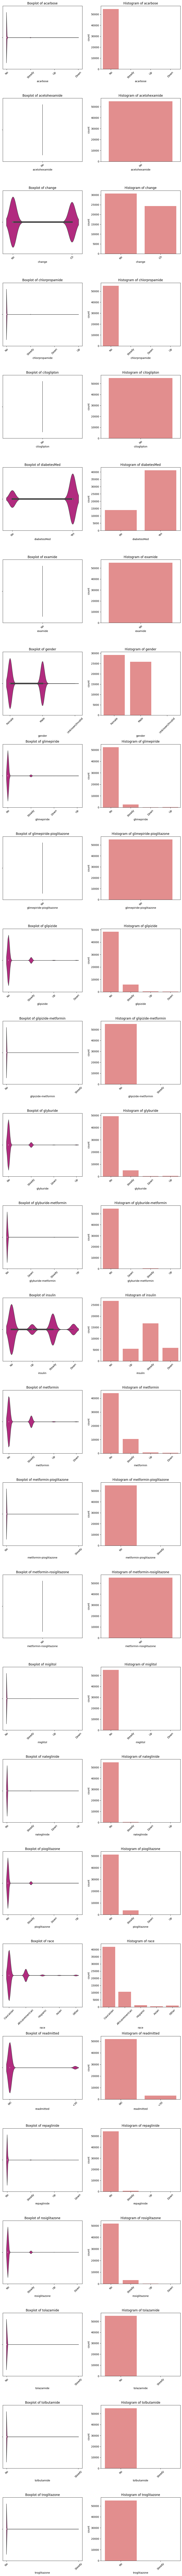

In [27]:
# analyze the distributions in the categorical data
plot_categorical_distributions(df)

In [28]:
def display_chi_square_columns(df, target_col):
    """Generates a DataFrame analyzing columns' null values.

    Args:
        df (pd.DataFrame): A dataset containing categorical columns.
        target_col (str): A variable that is being predicted on.

    Returns:
        pd.DataFrame: A DataFrame containing chi-square and p-value statistics.
    """

    # get categorical columns, except for identifier columns and the target
    categorical_cols = df.select_dtypes(include=["category", "object"]).columns
    categorical_df = df[categorical_cols].copy()
    categorical_df.drop(columns=["encounter_id", "patient_nbr", target_col], inplace=True)

    # initialize a dictionary to hold the chi-square test results
    result_dict = {"column_name": [], "chi_sq": [], "p_val": []}

    for col in categorical_df:

        # compute the contingency table
        contingency_table = pd.crosstab(df[col], df[target_col])

        # computes the chi-square statistic and p-value
        chi_sq, p_val, _, _ = chi2_contingency(contingency_table)

        # append the results
        result_dict["column_name"].append(col)
        result_dict["chi_sq"].append(round(chi_sq, 2))
        result_dict["p_val"].append(round(p_val, 2))

    # create a DataFrame from the results
    result_df = pd.DataFrame(result_dict).sort_values(by="p_val")
    result_df["is_significant"] = result_df["p_val"] < 0.05

    print(f"Columns with/without a significant association to the column, {target_col}:")

    return result_df

In [29]:
# create a DF showing chi-square and p-value statistics
display_chi_square_columns(df, "readmitted")

Columns with/without a significant association to the column, readmitted:


,column_name,chi_sq,p_val,is_significant
0,race,78.74,0.00,True
34,disease_class_1,104.31,0.00,True
33,description,403.31,0.00,True
32,diabetesMed,50.20,0.00,True
31,change,9.88,0.00,True
25,insulin,45.24,0.00,True
20,miglitol,17.25,0.00,True
35,disease_class_2,70.38,0.00,True
14,glipizide,25.32,0.00,True
36,disease_class_3,54.16,0.00,True


## Feature Engineering <a class="anchor" id="feature_engineering"></a>

In [30]:
cols_to_log = ["num_medications", "num_procedures", "number_emergency", "number_inpatient", "number_outpatient", "time_in_hospital"]

# log transform some of the numeric columns
for col in cols_to_log:
    df[f"{col}_log"] = np.log1p(df[col])

In [31]:
# look again at the skew to see if it improved
display_skewness_columns(df)

,column_name,value,skew_category
6,number_emergency,17.183030,High
5,number_outpatient,9.050615,High
11,number_emergency_log,4.106355,High
7,number_inpatient,3.910503,High
13,number_outpatient_log,3.110408,High
12,number_inpatient_log,1.805914,High
4,num_medications,1.418247,High
3,num_procedures,1.230317,High
1,time_in_hospital,1.162434,High
10,num_procedures_log,0.437913,Symmetric


In [32]:
# convert target values to numeric
df["readmitted"] = df["readmitted"].map({"NO": 0, "<30": 1})

In [33]:
# choose a subset of the data
numeric_features = ["age", "num_lab_procedures", "num_medications_log", "num_procedures_log", "number_diagnoses", "time_in_hospital_log"]
categorical_features = ["admission_type_id", "diabetesMed", "disease_class_1", "disease_class_2", "disease_class_3", "race"]
X = df[numeric_features + categorical_features]
y = df["readmitted"]

In [34]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
transformer = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_features),
    ("categorical", OneHotEncoder(drop="first", sparse_output=False), categorical_features)
])

# encode the categorical features and scale the numeric features
X_train_processed = transformer.fit_transform(X_train)
X_test_processed = transformer.transform(X_test)

In [36]:
# retrieve the feature names
categorical_cols = transformer.named_transformers_["categorical"].get_feature_names_out(categorical_features)
numeric_cols = transformer.named_transformers_["numeric"].get_feature_names_out(numeric_features)
feature_cols = list(numeric_cols) + list(categorical_cols)

# convert back to a DataFrame
X_train_final = pd.DataFrame(X_train_processed, columns=feature_cols, index=X_train.index)
X_test_final = pd.DataFrame(X_test_processed, columns=feature_cols, index=X_test.index)

In [37]:
def train_and_evaluate_models(models, X_train, X_test, y_train, y_test):
    """Trains three classification models, makes predictions, and evaluates performance.

    Trains and makes predictions on a dataset using three models (Logistic Regression,
    Random Forest Classifier, and XGBoost Classifier) and computes key classification
    performance metrics (accuracy, precision, recall, F1)

    Args:
        models (dict): A dictionary of models to train. Format: {"Model Name": model_instance}.
        X_train (pd.DataFrame): A dataset containing feature data used for model training.
        X_test (pd.DataFrame): A dataset containing feature data used for model testing.
        y_train (pd.Series): A single column of data used for model training.
        y_test (pd.Series): A single column of data used for model testing.
    """

    for model_name, model in models.items():

        # train the model and generate predictions
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # compute evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # generate and display confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y.unique())

        # print model performance metrics
        print("Model: ", model_name)
        print(f"Accuracy: {round(accuracy, 2)}, Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, F1 Score: {round(f1, 2)}")

        # plot the confusion matrix
        disp.plot(cmap="Greens", values_format="d")
        plt.title(f"Confusion Matrix - {model_name}")
        plt.show()

Model:  Logistic Regression
Accuracy: 0.59, Precision: 0.08, Recall: 0.62, F1 Score: 0.15


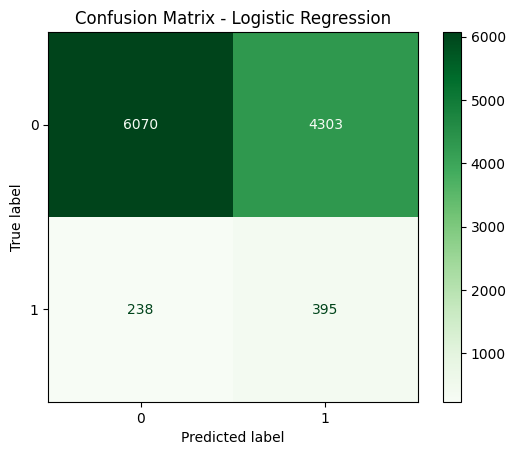

Model:  Random Forest Classifier
Accuracy: 0.94, Precision: 0.0, Recall: 0.0, F1 Score: 0.0


/Users/willnobles/Documents/datascience/metis-project3-classification/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


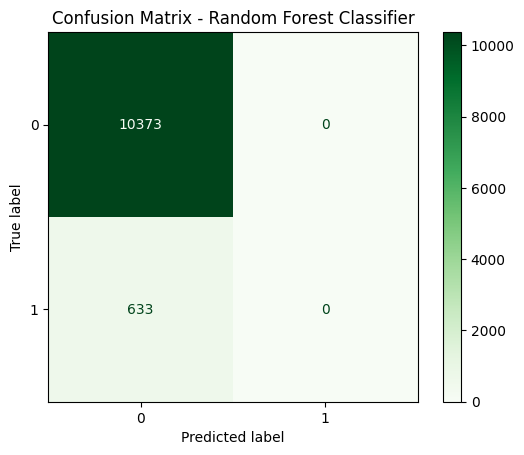

Model:  XGBoost
Accuracy: 0.73, Precision: 0.09, Recall: 0.41, F1 Score: 0.15


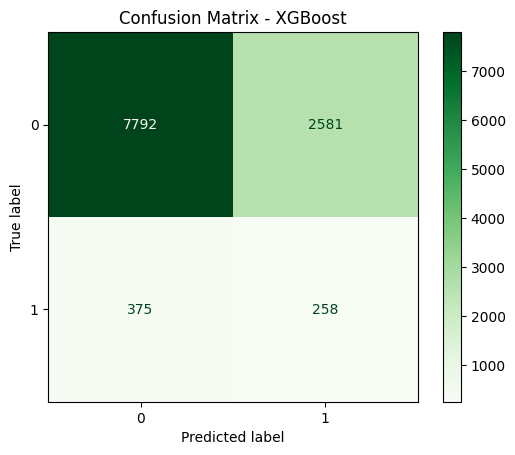

In [38]:
# initialize models
lr = LogisticRegression(class_weight="balanced", max_iter=500, random_state=42)
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
xgb = XGBClassifier(scale_pos_weight=16, random_state=42) # 51865 (NO) / 3164 (<30) = 16.4

# store in a dictionary
models = {"Logistic Regression": lr, "Random Forest Classifier": rf, "XGBoost": xgb}

# train the classifiers and analyze performance
train_and_evaluate_models(models, X_train_final, X_test_final, y_train, y_test)